In [19]:
import pandas as pd

In [20]:
movies = pd.read_csv('tmdb_5000_movies.csv')
movies = movies.drop(columns=['homepage', 'id','keywords','original_title','overview','production_companies','production_countries','release_date','spoken_languages','status','tagline','title'])

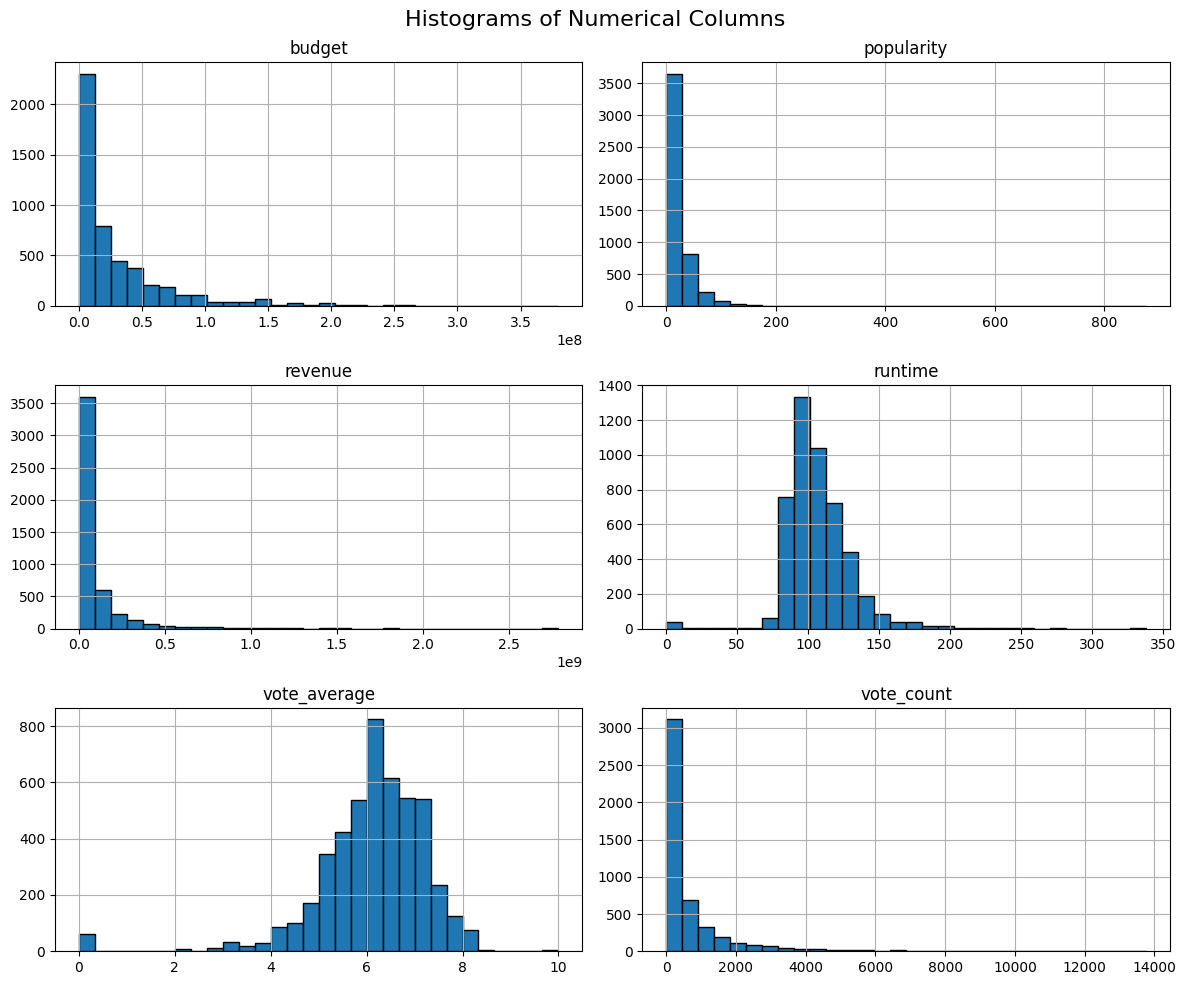

In [21]:
import matplotlib.pyplot as plt

numerical_columns = movies.select_dtypes(include=['number']).columns

movies[numerical_columns].hist(figsize=(12, 10), bins=30, edgecolor='black')

plt.suptitle('Histograms of Numerical Columns', fontsize=16)
plt.tight_layout()
plt.show()

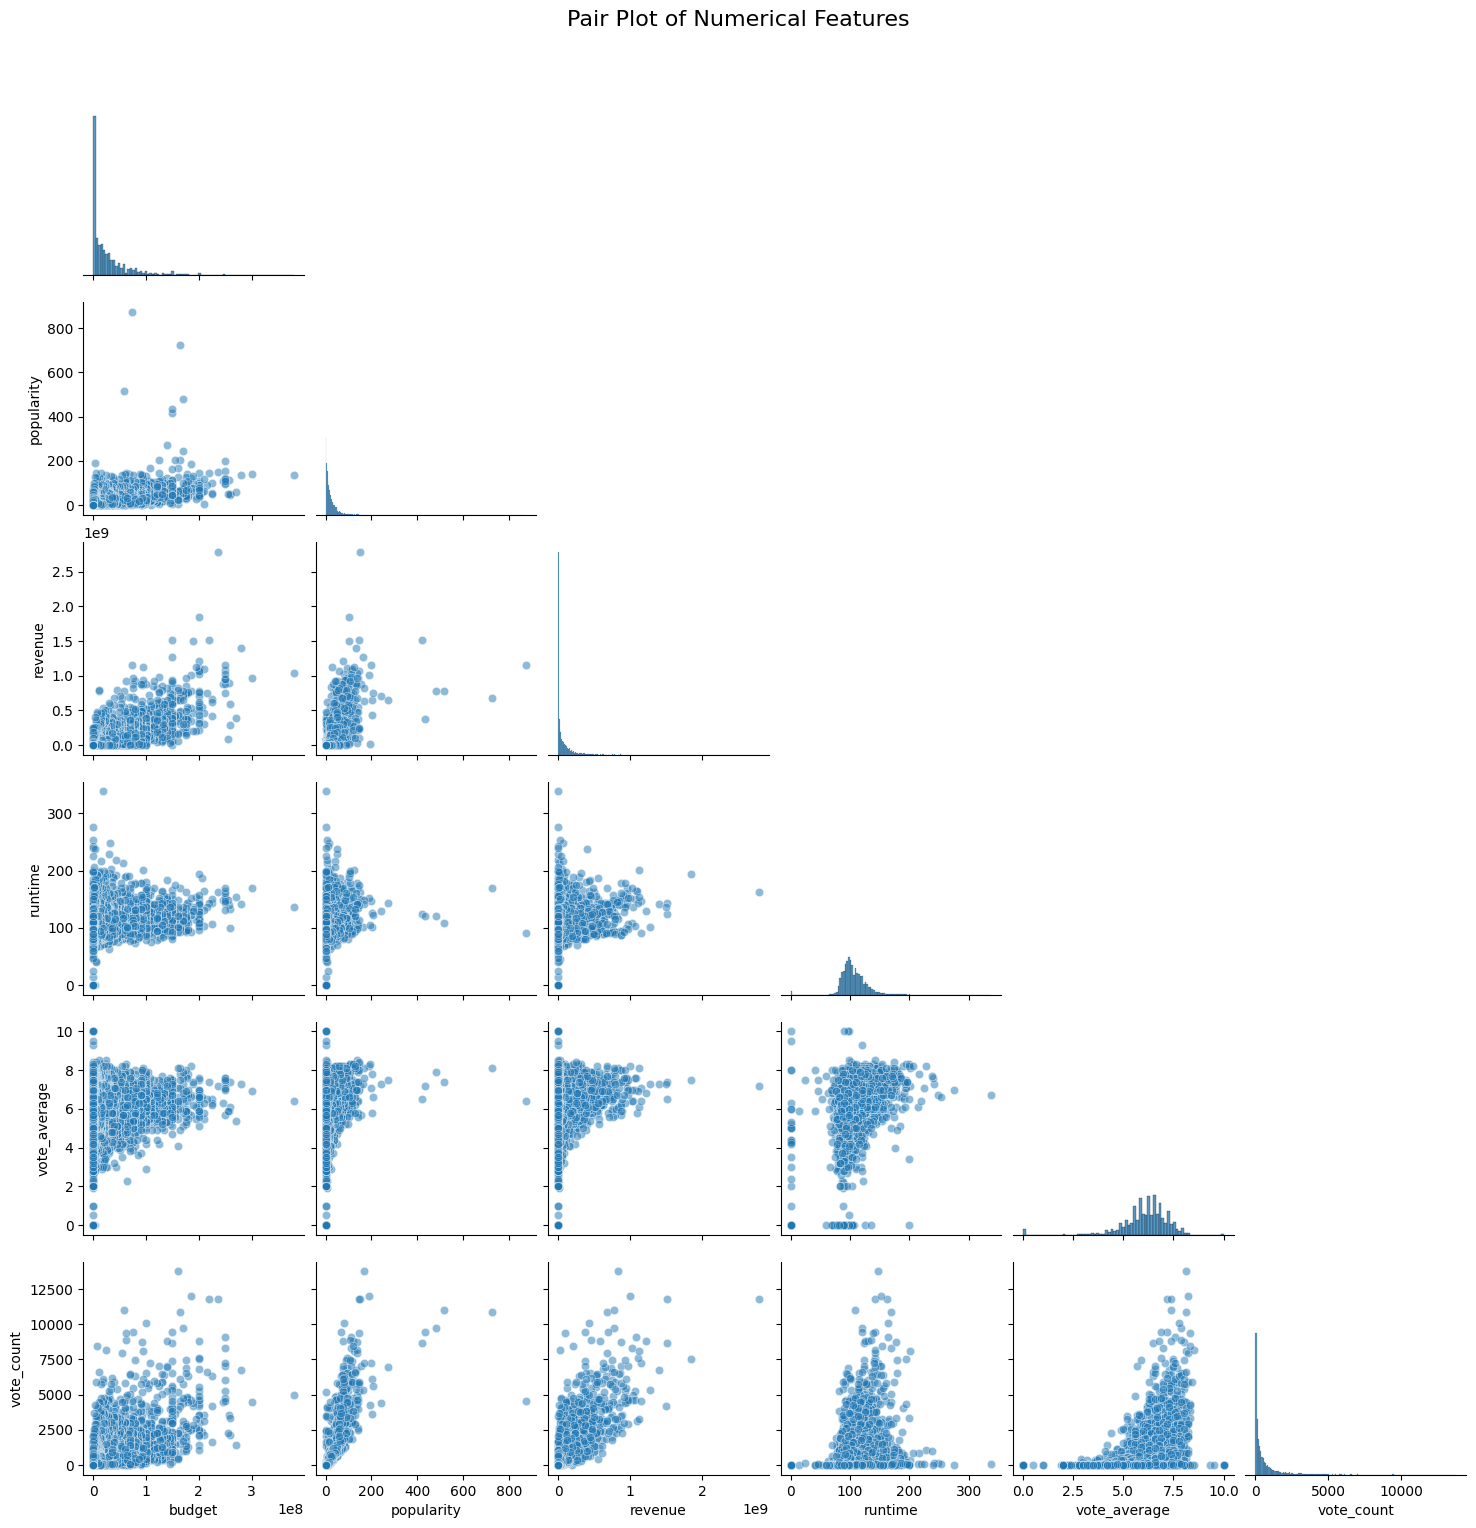

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(movies, diag_kind='hist', corner=True, plot_kws={'alpha': 0.5})

plt.suptitle('Pair Plot of Numerical Features', y=1.02, fontsize=16)

plt.show()

In [23]:

import ast
from sklearn.preprocessing import MinMaxScaler


def extract_genres(genres_str):
    try:
        return [genre['name'] for genre in ast.literal_eval(genres_str)]
    except (ValueError, TypeError):
        return []
    

movies['genres_list'] = movies['genres'].apply(extract_genres)
all_genres = set([genre for genres in movies['genres_list'] for genre in genres])
for genre in all_genres:
    movies[f'genre_{genre}'] = movies['genres_list'].apply(lambda x: 1 if genre in x else 0)
movies = movies.drop(columns=['genres', 'genres_list'])


columns_to_normalize = ['budget', 'popularity', 'runtime', 'vote_count','revenue','vote_average']
scaler = MinMaxScaler()
movies[columns_to_normalize] = scaler.fit_transform(movies[columns_to_normalize])
movies = movies.drop(columns=['original_language'])


movies = movies.dropna()
movies.to_csv('preprocessed_movies_full.csv', index=False)  


print(movies.head())


     budget  popularity   revenue   runtime  vote_average  vote_count  \
0  0.623684    0.171815  1.000000  0.479290          0.72    0.858057   
1  0.789474    0.158846  0.344696  0.500000          0.69    0.327225   
2  0.644737    0.122635  0.315884  0.437870          0.63    0.324753   
3  0.657895    0.128272  0.389151  0.488166          0.76    0.662158   
4  0.684211    0.050169  0.101916  0.390533          0.61    0.154450   

   genre_War  genre_Science Fiction  genre_Family  genre_TV Movie  ...  \
0          0                      1             0               0  ...   
1          0                      0             0               0  ...   
2          0                      0             0               0  ...   
3          0                      0             0               0  ...   
4          0                      1             0               0  ...   

   genre_Music  genre_Documentary  genre_Action  genre_Crime  genre_Mystery  \
0            0                  0    

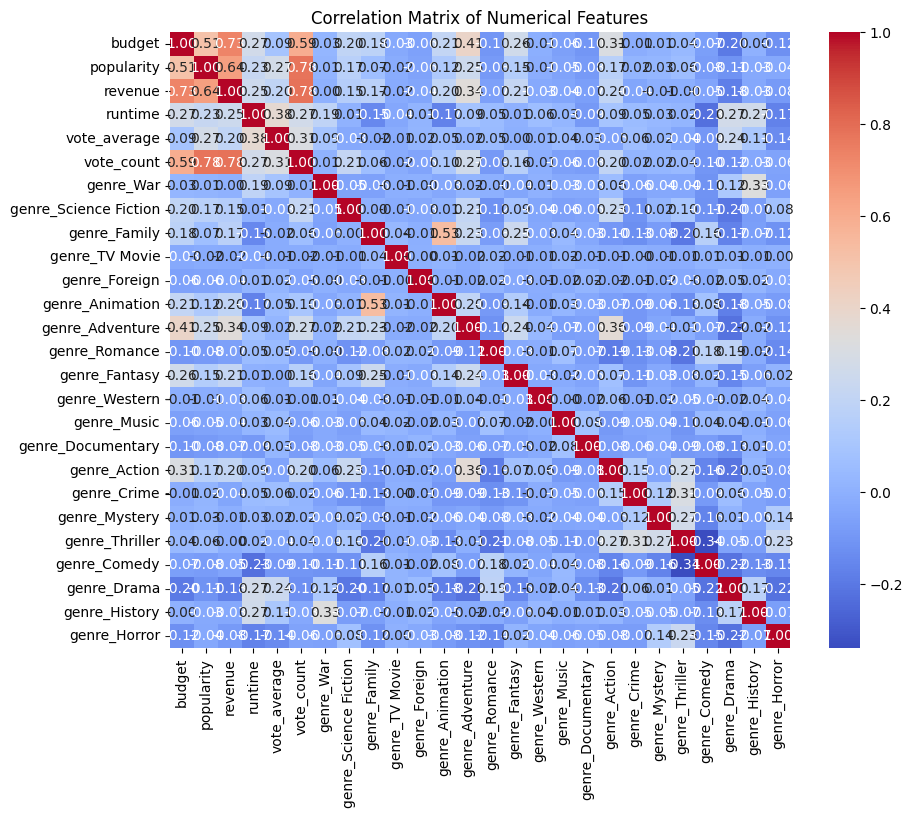

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = movies.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor 
from sklearn.linear_model import LinearRegression

movies = pd.read_csv('preprocessed_movies_full.csv')  
X = movies[['budget', 'popularity', 'runtime', 'vote_count']] 
y = movies[['revenue', 'vote_average']]  
movies=movies.drop(columns=['revenue','vote_average'])
X=movies

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_model = MultiOutputRegressor(LinearRegression())
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

print(y_pred[:5])

[[ 0.04294185  0.5235813 ]
 [-0.00862648  0.59476699]
 [-0.00114973  0.58995807]
 [ 0.02182817  0.5775842 ]
 [ 0.29076113  0.69581354]]


In [26]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae= mean_absolute_error(y_test,y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²) Score: {r2}")
print(f"Mean Absolute error:{mae}")

Mean Squared Error (MSE): 0.005510716386506127
R-squared (R²) Score: 0.5216111607464655
Mean Absolute error:0.04106672508822318


In [27]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor



rf_regressor = RandomForestRegressor(n_estimators=100,random_state=42)
rf_regressor.fit(X_train, y_train)


dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)


rf_predictions = rf_regressor.predict(X_test)


dt_predictions = dt_regressor.predict(X_test)


print("Random Forest Regressor Results:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, rf_predictions):.4f}")
print(f"R^2 Score: {r2_score(y_test, rf_predictions):.4f}")
print(f"mean absolute error: {mean_absolute_error(y_test, rf_predictions):.4f}")


print("\nDecision Tree Regressor Results:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, dt_predictions):.4f}")
print(f"R^2 Score: {r2_score(y_test, dt_predictions):.4f}")
print(f"mean absolute error: {mean_absolute_error(y_test, dt_predictions):.4f}")


Random Forest Regressor Results:
Mean Squared Error (MSE): 0.0033
R^2 Score: 0.6715
mean absolute error: 0.0335

Decision Tree Regressor Results:
Mean Squared Error (MSE): 0.0059
R^2 Score: 0.4214
mean absolute error: 0.0468


In [28]:

from sklearn.model_selection import RandomizedSearchCV
import numpy as np



rf = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_random_search = RandomizedSearchCV(rf, rf_param_grid, n_iter=20, cv=3, scoring='neg_mean_squared_error', random_state=42)
rf_random_search.fit(X_train, y_train)


best_rf = rf_random_search.best_estimator_
rf_predictions = best_rf.predict(X_test)


print("Optimized Random Forest Regressor Results:")
print(f"Best Parameters: {rf_random_search.best_params_}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, rf_predictions):.4f}")
print(f"R^2 Score: {r2_score(y_test, rf_predictions):.4f}")
print(f"mean absolute error: {mean_absolute_error(y_test, rf_predictions):.4f}")

dt = DecisionTreeRegressor(random_state=42)
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_random_search = RandomizedSearchCV(dt, dt_param_grid, n_iter=20, cv=3, scoring='neg_mean_squared_error', random_state=42)
dt_random_search.fit(X_train, y_train)


best_dt = dt_random_search.best_estimator_
dt_predictions = best_dt.predict(X_test)


print("\nOptimized Decision Tree Regressor Results:")
print(f"Best Parameters: {dt_random_search.best_params_}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, dt_predictions):.4f}")
print(f"R^2 Score: {r2_score(y_test, dt_predictions):.4f}")
print(f"mean absolute error: {mean_absolute_error(y_test, dt_predictions):.4f}")


Optimized Random Forest Regressor Results:
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 30}
Mean Squared Error (MSE): 0.0030
R^2 Score: 0.7185
mean absolute error: 0.0327

Optimized Decision Tree Regressor Results:
Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}
Mean Squared Error (MSE): 0.0039
R^2 Score: 0.6347
mean absolute error: 0.0372


In [43]:
a=X_test.iloc[1]
a

budget                   0.001447
popularity               0.000002
runtime                  0.289941
vote_count               0.000291
genre_War                0.000000
genre_Science Fiction    0.000000
genre_Family             0.000000
genre_TV Movie           0.000000
genre_Foreign            0.000000
genre_Animation          0.000000
genre_Adventure          0.000000
genre_Romance            0.000000
genre_Fantasy            0.000000
genre_Western            0.000000
genre_Music              0.000000
genre_Documentary        0.000000
genre_Action             0.000000
genre_Crime              0.000000
genre_Mystery            0.000000
genre_Thriller           1.000000
genre_Comedy             0.000000
genre_Drama              1.000000
genre_History            0.000000
genre_Horror             0.000000
Name: 4507, dtype: float64

In [29]:
import pickle

# Save the trained model to a .pkl file
with open('optimized_random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

print("Optimized Random Forest model saved as 'optimized_random_forest_model.pkl'.")


Optimized Random Forest model saved as 'optimized_random_forest_model.pkl'.


In [48]:
import pickle
import pandas as pd

with open('optimized_random_forest_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

print("Model loaded successfully!")

input_data = {
    'budget': 0.001447,
    'popularity': 0.000002,
    'runtime': 0.289941,
    'vote_count': 0.000291,
    'genre_War': 0.000000,
    'genre_Science Fiction': 0.000000,
    'genre_Family': 0.000000,
    'genre_TV Movie': 0.000000,
    'genre_Foreign': 0.000000,
    'genre_Animation': 0.000000,
    'genre_Adventure': 0.000000,
    'genre_Romance': 0.000000,
    'genre_Fantasy': 0.000000,
    'genre_Western': 0.000000,
    'genre_Music': 0.000000,
    'genre_Documentary': 0.000000,
    'genre_Action': 0.000000,
    'genre_Crime': 0.000000,
    'genre_Mystery': 0.000000,
    'genre_Thriller': 1.000000,
    'genre_Comedy': 0.000000,
    'genre_Drama': 1.000000,
    'genre_History': 0.000000,
    'genre_Horror': 0.000000
}

X_new = pd.DataFrame([input_data])

predictions = loaded_model.predict(X_new)

revenue_prediction, vote_average_prediction = predictions[0]

print("Predicted Revenue (normalized):", f"{revenue_prediction:.6f}")
print("Predicted Vote Average:", f"{vote_average_prediction:.6f}")

Model loaded successfully!
Predicted Revenue (normalized): 0.000196
Predicted Vote Average: 0.554394
